# Red Wines Quality
*Simple and clean practice dataset for regression or **classification** modelling*

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import plotly.graph_objects as go

## Spark Setup
*skip if not in Google Colab*

### JDK + SPARK



In [51]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [52]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

import findspark
findspark.init('spark-3.2.1-bin-hadoop3.2')

## Spark Session

In [53]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .master('local[*]') \
  .appName('Red Wine Quality Prediction') \
  .getOrCreate()


## Reading the data 

In [54]:
df =(spark.read
          .format('csv')
          .option('header', 'true')
          .load('./winequality-red.csv'))

df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|              0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|              0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0

In [55]:
from pyspark.sql.functions import col
df = df.select(col('fixed acidity').cast('float'),
                         col('volatile acidity').cast('float'),
                         col('citric acid').cast('float'),
                         col('residual sugar').cast('float'),
                         col('chlorides').cast('float'),
                         col('free sulfur dioxide').cast('float'),
                         col('total sulfur dioxide').cast('float'),
                         col('density').cast('float'),
                         col('pH').cast('float'),
                         col('sulphates').cast('float'),
                         col('alcohol').cast('float'),
                         col('quality').cast('int')
                        )

dataset = df.toPandas()
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Checking for null values

In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float32
 1   volatile acidity      1599 non-null   float32
 2   citric acid           1599 non-null   float32
 3   residual sugar        1599 non-null   float32
 4   chlorides             1599 non-null   float32
 5   free sulfur dioxide   1599 non-null   float32
 6   total sulfur dioxide  1599 non-null   float32
 7   density               1599 non-null   float32
 8   pH                    1599 non-null   float32
 9   sulphates             1599 non-null   float32
 10  alcohol               1599 non-null   float32
 11  quality               1599 non-null   int32  
dtypes: float32(11), int32(1)
memory usage: 75.1 KB


### Dataset info

In [57]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319636,1.741094,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409926,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460162,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467793,32.895329,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311108,0.154387,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658150,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


## Exploratory Data Analysis

### Wine Quality Distribuition

In [80]:
quality_plot_df = df.select(col('quality').cast('string')).toPandas()

fig = px.histogram(quality_plot_df, x='quality', title='Quality Distribuition', color_discrete_sequence=px.colors.qualitative.G10, category_orders=dict(quality=list(range(1,11))))
fig.show(renderer="colab")

### Features Distribuition

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3844601c90>,
      dtype=object)

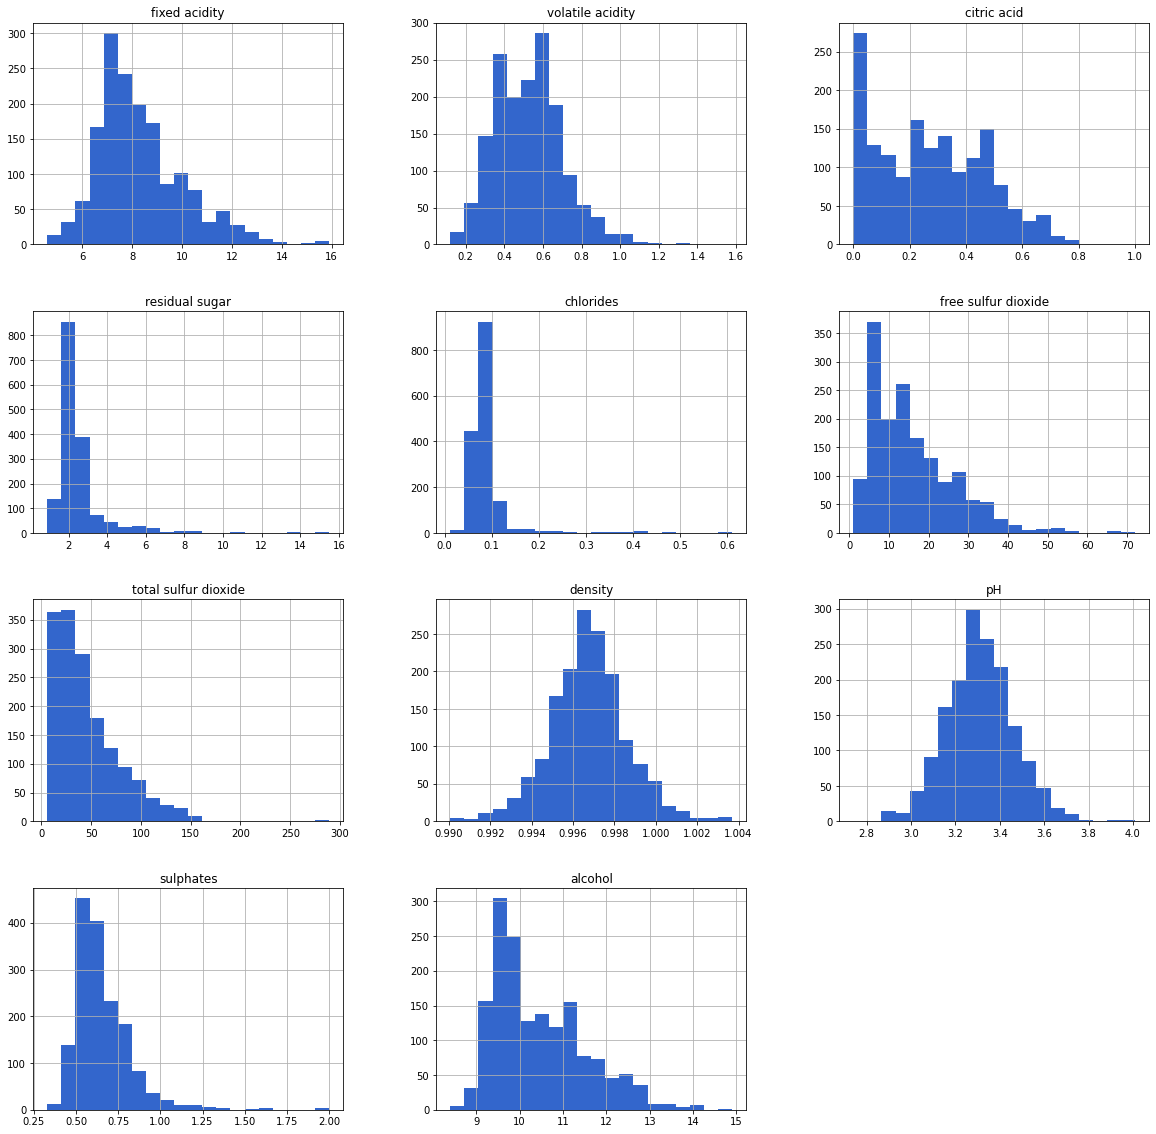

In [85]:
dataset.drop(labels='quality', axis=1).hist(bins=20, figsize=(20,20), color='#3366cc')

### Correlation Heatmap

In [60]:
dataset.columns.to_list()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [61]:
import plotly.graph_objects as go

correlation = dataset.corr()

numeric_columns = dataset.columns.to_list()

corr_heatmap = go.Figure(data=go.Heatmap(
                   colorscale=px.colors.sequential.Blues,
                   z=correlation.values,
                   x=numeric_columns,
                   y=numeric_columns,
                   hoverongaps = False))
corr_heatmap.update_layout(title='Correlation Heatmap')
corr_heatmap.show(renderer='colab')

### Feature Distribuition Among Quality

In [62]:
fig = px.box(dataset, x='quality', y='fixed acidity')
fig.show(render='colab')

In [63]:
fig = px.box(dataset, x='quality', y='citric acid')
fig.show(render='colab')

## Feature selection

In [64]:
features = ['fixed acidity',
            'volatile acidity',
            'citric acid',
            'residual sugar',
            'chlorides',
            'free sulfur dioxide',
            'total sulfur dioxide',
            'density',
            'pH',
            'sulphates',
            'alcohol']
dependent_variable = 'quality'

In [65]:
from pyspark.sql.functions import when

required_features = ['fixed acidity',
            'volatile acidity',
            'citric acid',
            'residual sugar',
            'chlorides',
            'free sulfur dioxide',
            'total sulfur dioxide',
            'density',
            'pH',
            'sulphates',
            'alcohol']

from pyspark.ml.feature import VectorAssembler

df = df.withColumn('wine_quality', when(df.quality >= 6, 1).otherwise(0))
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(df)

In [66]:
transformed_data.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|wine_quality|            features|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|           0|[7.40000009536743...|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|           0|[7.80000019073486...|
|          7.8|            0.76|       0.04|           2.3|    0.092|           

## Feature Engineering

### Scaling all features using standard scaler

In [67]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(transformed_data)
scaledData = scalerModel.transform(transformed_data)

In [68]:
scaledData.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+------------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|wine_quality|            features|      scaledFeatures|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+------------+--------------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|           0|[7.40000009536743...|[4.25019570652240...|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|           0|[7.80000019073486.

## Training

In [69]:
(training_data, test_data) = scaledData.randomSplit([0.75,0.25])

### Linear SVC Classification

In [70]:
from pyspark.ml.classification import LinearSVC

def train_svc_model(training_data, depth):
  rf = LinearSVC(labelCol='wine_quality', featuresCol='scaledFeatures')
  model = rf.fit(training_data)
  return model

### GBT Classification

In [71]:
from pyspark.ml.classification import GBTClassifier


def train_gbt_model(training_data, depth):
  rf = GBTClassifier(labelCol='wine_quality', 
                            featuresCol='scaledFeatures',
                            maxDepth=depth)
  model = rf.fit(training_data)
  return model

### Decision Tree Classification

In [72]:
from pyspark.ml.classification import DecisionTreeClassifier


def train_decision_tree_model(training_data, depth):
  rf = DecisionTreeClassifier(labelCol='wine_quality', 
                            featuresCol='scaledFeatures',
                            maxDepth=depth)
  model = rf.fit(training_data)
  return model

### Random Forest Classification

In [73]:
from pyspark.ml.classification import RandomForestClassifier


def train_random_forest_model(training_data, depth):
  rf = RandomForestClassifier(labelCol='wine_quality', 
                            featuresCol='scaledFeatures',
                            maxDepth=depth)
  model = rf.fit(training_data)
  return model

In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def build_evaluator(metricName):
  return MulticlassClassificationEvaluator(
    labelCol='wine_quality', 
    predictionCol='prediction', 
    metricName=metricName)

def evaluate_model(model, predictions): 
  accuracy_evaluator = build_evaluator('accuracy')
  f1_evaluator = build_evaluator('f1')

  accuracy = accuracy_evaluator.evaluate(predictions)
  f1_score = f1_evaluator.evaluate(predictions)

  print(f'Model Accuracy: {accuracy:.4f}')
  print(f'F1 Score: {f1_score:.4f}')



## Model evaluation

In [75]:
print('Decision Tree')


for depth in range(1, 21): 
  model = train_decision_tree_model(training_data, depth)

  predictions = model.transform(test_data)
  evaluate_model(model, predictions)

Decision Tree
Model Accuracy: 0.7157
F1 Score: 0.7163
Model Accuracy: 0.7157
F1 Score: 0.7163
Model Accuracy: 0.7132
F1 Score: 0.7077
Model Accuracy: 0.7207
F1 Score: 0.7188
Model Accuracy: 0.7431
F1 Score: 0.7435
Model Accuracy: 0.7132
F1 Score: 0.7131
Model Accuracy: 0.7232
F1 Score: 0.7233
Model Accuracy: 0.7332
F1 Score: 0.7315
Model Accuracy: 0.7481
F1 Score: 0.7475
Model Accuracy: 0.7332
F1 Score: 0.7327
Model Accuracy: 0.7456
F1 Score: 0.7447
Model Accuracy: 0.7456
F1 Score: 0.7447
Model Accuracy: 0.7556
F1 Score: 0.7537
Model Accuracy: 0.7481
F1 Score: 0.7468
Model Accuracy: 0.7581
F1 Score: 0.7564
Model Accuracy: 0.7581
F1 Score: 0.7564
Model Accuracy: 0.7581
F1 Score: 0.7564
Model Accuracy: 0.7581
F1 Score: 0.7564
Model Accuracy: 0.7581
F1 Score: 0.7564
Model Accuracy: 0.7581
F1 Score: 0.7564


In [76]:
print('GBT')

for depth in range(1, 21): 
  model = train_gbt_model(training_data, depth)

  predictions = model.transform(test_data)
  evaluate_model(model, predictions)

GBT
Model Accuracy: 0.7406
F1 Score: 0.7409
Model Accuracy: 0.7581
F1 Score: 0.7587
Model Accuracy: 0.7357
F1 Score: 0.7339
Model Accuracy: 0.7531
F1 Score: 0.7532
Model Accuracy: 0.7431
F1 Score: 0.7435
Model Accuracy: 0.7656
F1 Score: 0.7651
Model Accuracy: 0.7880
F1 Score: 0.7880
Model Accuracy: 0.7631
F1 Score: 0.7630
Model Accuracy: 0.7731
F1 Score: 0.7727
Model Accuracy: 0.7581
F1 Score: 0.7569
Model Accuracy: 0.7481
F1 Score: 0.7468
Model Accuracy: 0.7531
F1 Score: 0.7518
Model Accuracy: 0.7481
F1 Score: 0.7468
Model Accuracy: 0.7531
F1 Score: 0.7516
Model Accuracy: 0.7531
F1 Score: 0.7516
Model Accuracy: 0.7531
F1 Score: 0.7516
Model Accuracy: 0.7531
F1 Score: 0.7516
Model Accuracy: 0.7531
F1 Score: 0.7516
Model Accuracy: 0.7531
F1 Score: 0.7516
Model Accuracy: 0.7531
F1 Score: 0.7516


In [77]:
print('Random Forest')

for depth in range(1, 21): 
  model = train_random_forest_model(training_data, depth)

  predictions = model.transform(test_data)
  evaluate_model(model, predictions)

Random Forest
Model Accuracy: 0.7481
F1 Score: 0.7473
Model Accuracy: 0.7531
F1 Score: 0.7527
Model Accuracy: 0.7481
F1 Score: 0.7483
Model Accuracy: 0.7506
F1 Score: 0.7509
Model Accuracy: 0.7731
F1 Score: 0.7730
Model Accuracy: 0.7756
F1 Score: 0.7756
Model Accuracy: 0.7805
F1 Score: 0.7807
Model Accuracy: 0.7905
F1 Score: 0.7906
Model Accuracy: 0.8005
F1 Score: 0.8006
Model Accuracy: 0.8080
F1 Score: 0.8080
Model Accuracy: 0.8204
F1 Score: 0.8207
Model Accuracy: 0.8204
F1 Score: 0.8208
Model Accuracy: 0.8204
F1 Score: 0.8207
Model Accuracy: 0.8180
F1 Score: 0.8183
Model Accuracy: 0.8204
F1 Score: 0.8207
Model Accuracy: 0.8229
F1 Score: 0.8232
Model Accuracy: 0.8229
F1 Score: 0.8232
Model Accuracy: 0.8204
F1 Score: 0.8207
Model Accuracy: 0.8204
F1 Score: 0.8207
Model Accuracy: 0.8204
F1 Score: 0.8207


In [78]:
print('SVC')

model = train_svc_model(training_data, depth)

predictions = model.transform(test_data)
evaluate_model(model, predictions)

SVC
Model Accuracy: 0.7556
F1 Score: 0.7555


## Conclusion
Almost all features have a good correlation

Better to compute quality into a binary variable (*wine_quality*) instead of trying to predicting the quality itself

**Random Forest is the winner** - better accuracy and F1 Score